In [14]:
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

#### Load easy dataset - breast cancer

In [15]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer_features_df = pd.DataFrame.from_dict(breast_cancer['data']['features'])
breast_cancer_classes_df = pd.DataFrame.from_dict(breast_cancer['data']['targets'])
pd.concat([breast_cancer_classes_df, breast_cancer_features_df], axis=1)
breast_cancer_classes_df.shape

(569, 1)

In [16]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
X = breast_cancer_features_df
breast_cancer_lb_diagnosis = LabelBinarizer()

y = np.squeeze(breast_cancer_lb_diagnosis.fit_transform(breast_cancer_classes_df))

In [17]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
def evaluate(clf, X, y, scoring=None) -> dict:
    scoring = scoring or ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    _scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=8, return_train_score=True)
    return {name: score.mean() for name, score in _scores.items()}

# Stacking
Celem jest porównanie Stosowania Lasów Losowych (Stacking Random Forest) z klasycznymi Lasami Losowymi oraz klasycznym Stosowaniem (z różnorodnymi estymatorami bazowymi).

**Stosowanie Lasów Losowych (Stacking Random Forest)**:

- jako estymator końcowy używamy kolejnego Lasu Losowego
- jako estymatory bazowe używamy Lasów Losowych

**Klasyczne Stosowanie (Classic Stacking)**:

- jako estymatory bazowe używamy różnorodnych klasyfikatorów: Naiwny Bayes, Drzewo Decyzyjne, KNN, SVM, Regresja Logistyczna
- jako estymator końcowy używamy kolejnego Lasu Losowego

**Klasyczne Lasy Losowe (Classic Random Forest)**:

- klasyczne Lasy Losowe

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

clf = StackingClassifier(estimators=[(f"tree{i}", RandomForestClassifier()) for i in range(16)],
                         final_estimator=RandomForestClassifier())


In [21]:
num_estimators = list(range(1, 17))
measures = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
res = [evaluate(StackingClassifier(estimators=[(f"tree{i}", RandomForestClassifier()) for i in range(n)],
                                   final_estimator=RandomForestClassifier()), X, y, scoring=measures) for n in
       num_estimators]

In [22]:
res_ref = [evaluate(RandomForestClassifier(
    max_depth=None,
    n_estimators=num_estimator,
    n_jobs=8
), X, y, scoring=measures) for num_estimator in num_estimators]

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

res_variety = [evaluate(StackingClassifier(estimators=[
    ("nb", GaussianNB()),
    ("tree", DecisionTreeClassifier()),
    ("rf", RandomForestClassifier()),
    ("knn", KNeighborsClassifier()),
    ("svm", LinearSVC()),
    ("lr", LogisticRegression())
], final_estimator=RandomForestClassifier()), X, y, scoring=measures) for n in num_estimators]

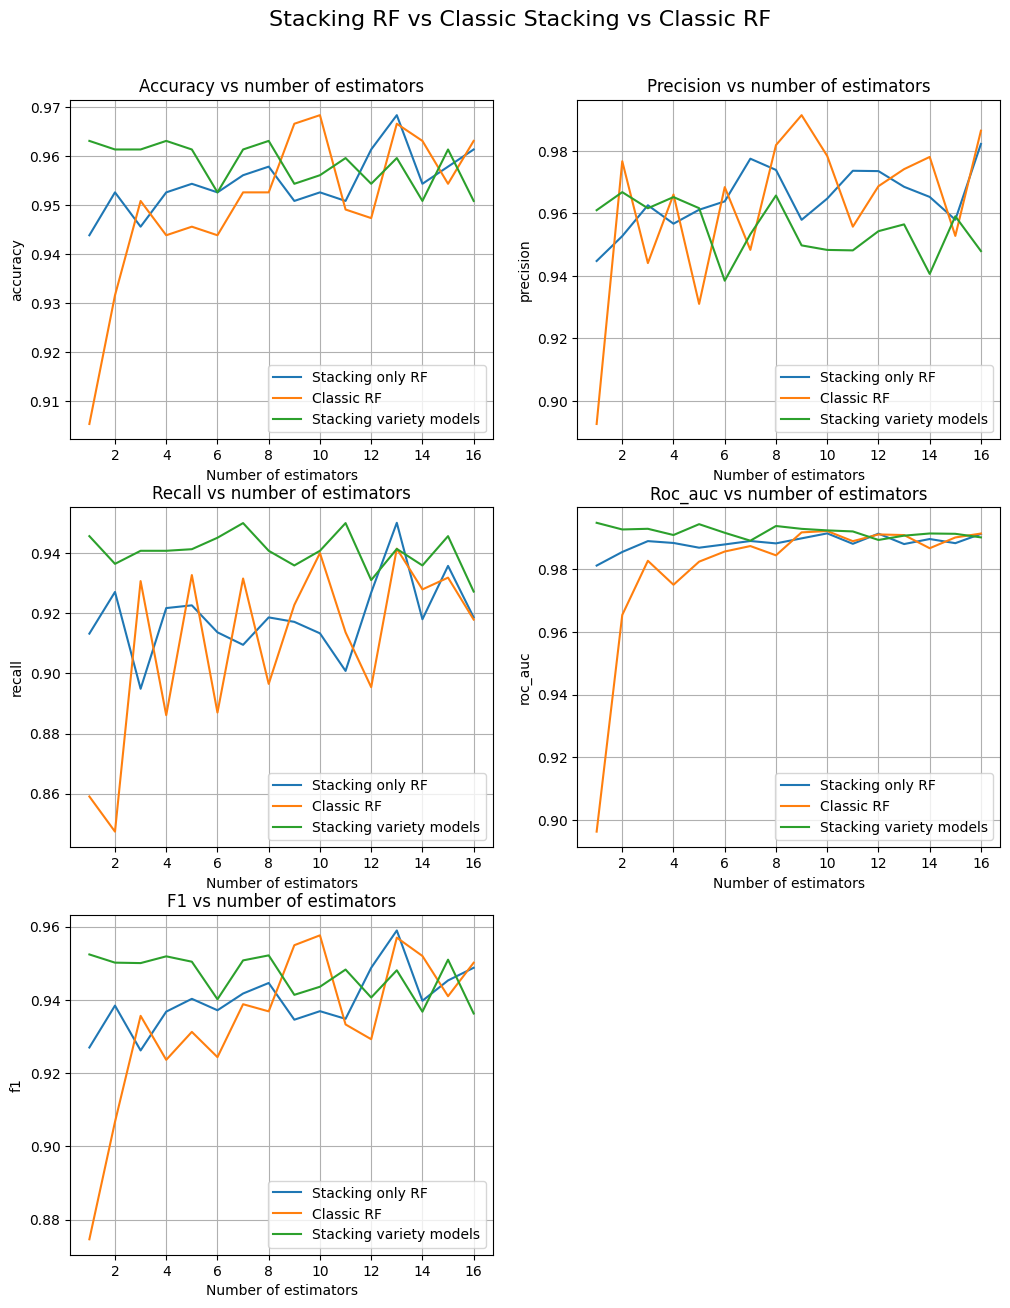

In [26]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res]
    _y_ref = [r[f"test_{measure}"] for r in res_ref]
    _y_variety = [r[f"test_{measure}"] for r in res_variety]
    ax.plot(num_estimators, _y, label="Stacking only RF")
    ax.plot(num_estimators, _y_ref, label="Classic RF")
    ax.plot(num_estimators, _y_variety, label="Stacking variety models")
    ax.set_xlabel("Number of estimators")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of estimators")
    
fig.suptitle("Stacking RF vs Classic Stacking vs Classic RF", fontsize=16, y=0.94)
    
axes.reshape(-1)[-1].set_visible(False)

plt.show()

#### Load hard dataset - statlog german credit data

In [27]:
from ucimlrepo import fetch_ucirepo

statlog_german_credit_data = fetch_ucirepo(id=144)


from sklearn.preprocessing import LabelEncoder, LabelBinarizer

statlog_german_credit_data_df = pd.DataFrame.from_dict(statlog_german_credit_data.data.features)
statlog_german_credit_data_df['class'] = statlog_german_credit_data.data.targets['class']
statlog_german_credit_data_df['class'] = statlog_german_credit_data_df['class'].astype(str)

encoded_features = statlog_german_credit_data_df.columns
label_encoders = {feature: LabelEncoder() for feature in encoded_features}
for feature, encoder in label_encoders.items():
    statlog_german_credit_data_df[feature] = encoder.fit_transform(statlog_german_credit_data_df[feature])

X = statlog_german_credit_data_df.drop(['class'], axis='columns')
y = statlog_german_credit_data_df['class']

In [28]:
num_estimators = list(range(1, 17))
measures = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
res = [evaluate(StackingClassifier(estimators=[(f"tree{i}", RandomForestClassifier()) for i in range(n)],
                                   final_estimator=RandomForestClassifier()), X, y, scoring=measures) for n in
       num_estimators]
res_ref = [evaluate(RandomForestClassifier(
    max_depth=None,
    n_estimators=num_estimator,
    n_jobs=8
), X, y, scoring=measures) for num_estimator in num_estimators]

In [ ]:
res_variety = [evaluate(StackingClassifier(estimators=[
    ("nb", GaussianNB()),
    ("tree", DecisionTreeClassifier()),
    ("rf", RandomForestClassifier()),
    ("knn", KNeighborsClassifier()),
    ("svm", LinearSVC()),
    ("lr", LogisticRegression())
], final_estimator=RandomForestClassifier()), X, y, scoring=measures) for n in num_estimators]

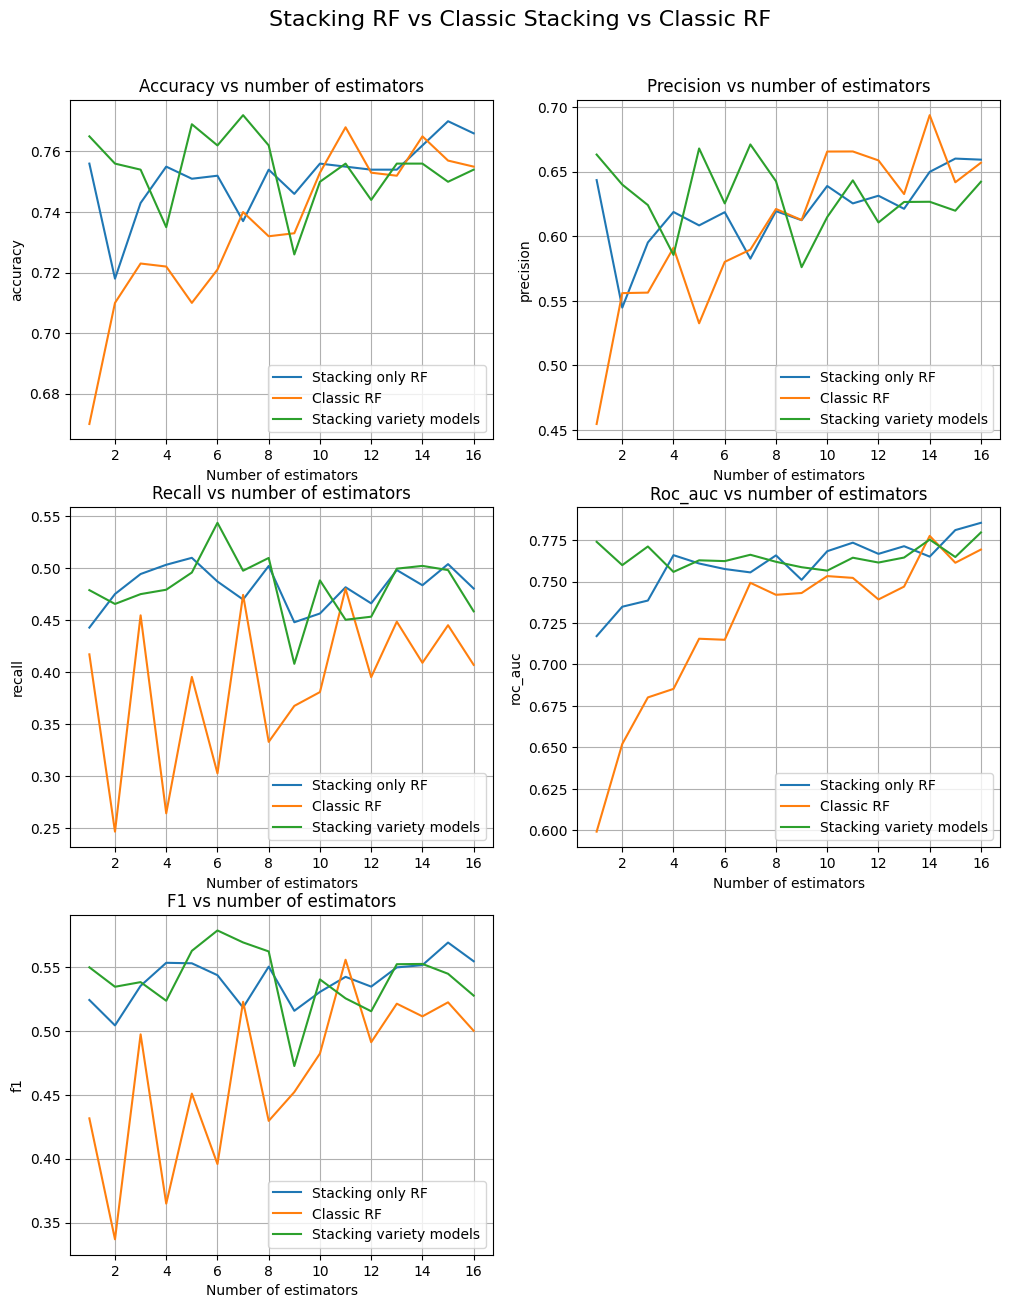

In [30]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res]
    _y_ref = [r[f"test_{measure}"] for r in res_ref]
    _y_variety = [r[f"test_{measure}"] for r in res_variety]
    ax.plot(num_estimators, _y, label="Stacking only RF")
    ax.plot(num_estimators, _y_ref, label="Classic RF")
    ax.plot(num_estimators, _y_variety, label="Stacking variety models")
    ax.set_xlabel("Number of estimators")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of estimators")
    
fig.suptitle("Stacking RF vs Classic Stacking vs Classic RF", fontsize=16, y=0.94)
    
axes.reshape(-1)[-1].set_visible(False)

plt.show()

# Wnioski na temat stosowania (stacking)

- Teoretyczna teza, że stosowanie różnorodnych modeli powinno być lepsze niż stosowanie tych samych modeli, została potwierdzona.
    - klasyczne stosowanie z różnorodnymi modelami zazwyczaj jest nieco lepsze niż stosowanie wyłącznie Lasów Losowych (RF)
    - możemy połączyć zalety różnorodności estymatorów bazowych, czego nie osiągniemy stosując wyłącznie Lasy Losowe
- modele mają podobny stosunek metryk (stosowanie RF do klasycznego stosowania do klasycznego RF) zarówno w trudnym zbiorze danych (ok. 97% dokładności) jak i łatwym zbiorze danych (ok. 98% dokładności)
- klasyczne Lasy Losowe mogą osiągnąć wyniki podobne do modeli stosujących przez zwiększenie liczby estymatorów.